In [1]:
import pandas as pd
import numpy as np

/Users/shreshtvenkatraman/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Do investor flows increase the prices of certain securities, or do investors buy securities with high prices?


In [2]:
def make_instrument (start = '', end = '', duration = 0):
    
    if len(end) == 0:
        dates_series =pd.date_range(start,periods = duration)
    elif duration > 0:
        dates_series = pd.date_range(start , end)
        
    paydays = dates_series + pd.tseries.offsets.SemiMonthEnd(0)
    z1 = (paydays == dates_series).astype(float)
    z2 = z1*0.25
    
    inst_df = pd.DataFrame({'Z1': z1, 'Z2': z2, 'Dates': dates_series})
    return inst_df

In [3]:
#from numpy import random

rng = np.random.default_rng(216)
N = 1000

df = make_instrument(start = '1/1/2020', duration = N)

In [4]:
df

,Z1,Z2,Dates
0,0.0,0.0,2020-01-01
1,0.0,0.0,2020-01-02
2,0.0,0.0,2020-01-03
3,0.0,0.0,2020-01-04
4,0.0,0.0,2020-01-05
...,...,...,...
995,0.0,0.0,2022-09-22
996,0.0,0.0,2022-09-23
997,0.0,0.0,2022-09-24
998,0.0,0.0,2022-09-25


We assume we observe approximately three years of data, so we will simulate 1000 days of observations. 

Our instrument, payday, can be 0 or 1, either a day is a payday, or it isn't. We assume that the 15th and last day of the month are paydays2, and a payday is unrelated to returns, except for how it influences the number of investors holding a security.

We'll call payday 𝑍 when discussing the math of instrumental variables below. We offer a function
to create a payday indicator, based on a set of dates:

𝑈, which we can't observe in our data analysis, but which affects both holdings and returns, is distributed 𝑁(1,1) (normally, with a mean of 1, and a standard deviation of 1). 

𝑋, the number of users holding a security is downstream of payday, and is deterministic in this
setup, it is the sum of 𝑈 and 𝑍. 

𝛽, the coefficient on 𝑋 is distributed 𝑁𝑁(1, .1) (normally, with a mean of 1, and a standard deviation of .1) , 

𝑌, the outcome, is distributed 𝑁(𝑈 + 𝑋𝛽, 1), (normally, with a mean that’s the sum of the variables times the slope plus the unobserved variable, and a standard deviation of 1).

Thus, there is an unobserved confounder, 𝑈, which affects both 𝑋 and 𝑌. Our simulated
𝛽 = 1.11.

In [5]:
u = rng.normal(size = N, loc = 1, scale = 1).reshape(N,1) ## CONFOUNDING VARIABLE
x = rng.normal(u + df['Z1'].values.reshape(N,1)).reshape(N,1) ## SUM OF U and Z (NUMBER OF USERS HOLDING A SECURITY)

beta = rng.normal(size = 1, loc = 1, scale = 0.1).reshape(1,1) ## COEFFICIENT

y = rng.normal(loc = u + np.matmul(x,beta), scale = 1) ## DEPENDANT VARIAVLE ALSO AFFECTED BY U;

df['X'] = x[:, 0]
df['Y'] = y[:, 0]

print("beta{}:".format(beta))


beta[[1.1099157]]:


In [6]:
rng.normal(size = 1, loc = 1, scale = 0.1).reshape(1,1)

array([[1.06140332]])

<Axes: ylabel='Frequency'>

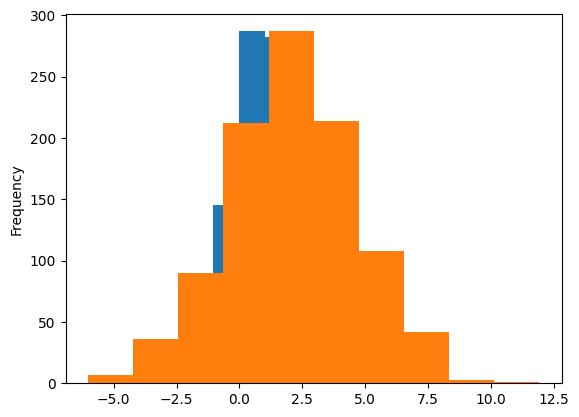

In [7]:
df['X'].plot(kind = 'hist')
df['Y'].plot(kind = 'hist')

In [8]:
import statsmodels.formula.api as smf

print(smf.ols('Y~X', df).fit().summary())

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     3225.
Date:                Mon, 03 Jun 2024   Prob (F-statistic):          6.71e-315
Time:                        11:20:19   Log-Likelihood:                -1625.7
No. Observations:                1000   AIC:                             3255.
Df Residuals:                     998   BIC:                             3265.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3876      0.050      7.747      0.0

### The above coefficient for X - 1.53 does not represent the True Beta as it is biased due to the confounding variable U

### We solve this issue using to 2SLS - 2 Stage Least Squares:-

we can regress 𝑋 on 𝑍, isolating the amount of 𝑋 caused by 𝑍, and
then, regress Y on the predictions from that model. Thus, we can estimate the **Local Average Treatment Effect (LATE)**, the effect of a subpopulation of 𝑋 on 𝑍, giving us the estimator:- 𝛽^iv

The LATE estimator can be implimented in a fairly straightforward manner using two OLS
equations:
* 𝑋 = 𝑍𝛾 + 𝜀
* 𝑌 = 𝑋*𝛽 + 𝜀 

X* refers to X predicted using Z


In [9]:
## Running 2SLS:

first_stage = smf.ols('X~Z1', data= df).fit()
df['x_star'] = first_stage.predict()

second_stage = smf.ols('Y~x_star', df).fit()
print(second_stage.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     10.72
Date:                Mon, 03 Jun 2024   Prob (F-statistic):            0.00110
Time:                        11:20:19   Log-Likelihood:                -2341.7
No. Observations:                1000   AIC:                             4687.
Df Residuals:                     998   BIC:                             4697.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9476      0.383      2.477      0.0

### Better estimation of Beta (less biased)

### However higher Std.Errors - Instrumental variables minimize bias at the cost of increasing variance


## Predicting from an IV model

If you want to use your instrumental variable regression to predict, you have to be clever.
The 2SLS implementation can suffer from numerical instability in prediction, and, if you
have a binary instrument (𝑍), you will only be able to observe predictions over the "local"
subset of your population. The predictions from this model are not particularly useful across
the range of 𝑋, they end up being dichotomous:

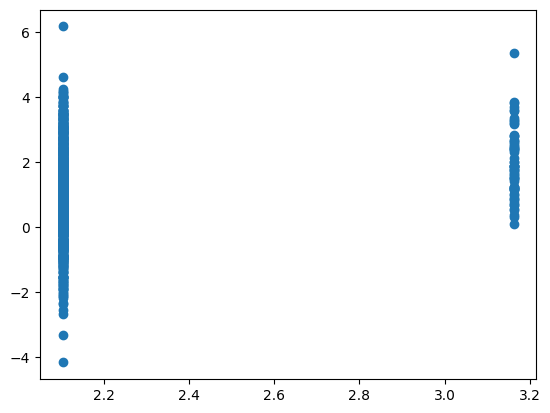

In [10]:
## Using Second Stage Predictionts to Predict Y

y_preds = second_stage.predict()
x = df['X']

import matplotlib.pyplot as plt
plt.scatter(y_preds, x)

As observed above, the predictions are limitted to 2 binary values?

## How to get Predictions on full range of X?

If you're willing to assume the local average treatment effect is equivalent to the average treatment effect 
**(LATE = ATE)**
you can use your original 𝑋 values in the second-stage equation, to
predict the causal effects across 𝑋. 

This involves first estimating the two stages as separate  OLS models, and then, using the original 𝑋 values to predict for the second stage. This allows you to predict 𝑌 across the entire range of 𝑋, rather than dichotomizing


/var/folders/73/jc80cx2x5tn05gttrc1j87780000gn/T/ipykernel_9471/3470824558.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_ate_preds = (x* second_stage.params[1]) + second_stage.params[0]


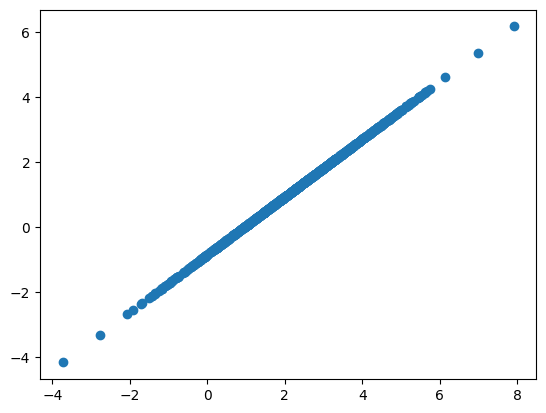

In [11]:
## Take 2SLS - Beta and Use it on Original X values [instead of on X* values]

y_ate_preds = (x* second_stage.params[1]) + second_stage.params[0]
plt.scatter(y_ate_preds, x)

/var/folders/73/jc80cx2x5tn05gttrc1j87780000gn/T/ipykernel_9471/1594801267.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_late_preds = (x *  first_stage.params[1]) + first_stage.params[0]


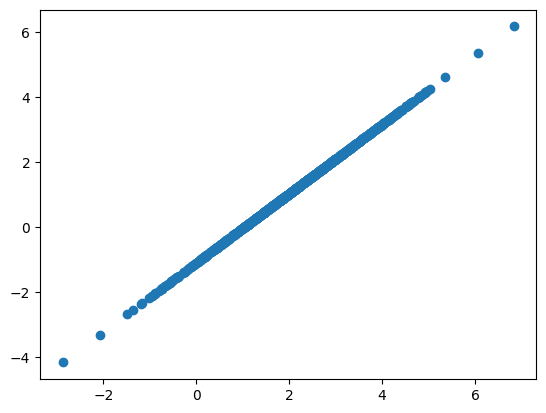

In [12]:
## Take 2SLS - Beta and Use it on Original X values [instead of on X* values]

y_late_preds = (x *  first_stage.params[1]) + first_stage.params[0]
plt.scatter(y_late_preds, x)

## The Exclusion Restriction

The key assumption that allows us to make a causal claim is the exclusion restriction. The
exclusion restriction requires that our instrument, payday (𝑍), only affects the outcome,
returns ( 𝑌 ), **through holdings ( 𝑋 )**, there is **no direct relationship between Y and Z**


### What happens when the exclusion restriction is violated?
We'll introduce just a little bit of correlation between payday and returns and see what happens

In [13]:
import linearmodels

zy_corr = np.ones(1)* 0.25

## introducing correaltion into y
y_restriction = rng.normal(
                loc = u + np.matmul(df.X.values.reshape(N,1), beta) +
                      np.matmul(df.Z1.values.reshape(N,1), zy_corr).reshape(N,1), 
                      scale = 1)

df['y_bad'] = y_restriction

iv_1 = linearmodels.iv.IV2SLS.from_formula(formula = "y_bad~ 1 + [X~Z1]", data = df).fit()

print(iv_1.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                  y_bad   R-squared:                      0.7455
Estimator:                    IV-2SLS   Adj. R-squared:                 0.7452
No. Observations:                1000   F-statistic:                    59.401
Date:                Mon, Jun 03 2024   P-value (F-stat)                0.0000
Time:                        11:20:21   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.7458     0.1974     3.7789     0.0002      0.3590      1.1326
X              1.3687     0.1776     7.7072     0.00

In [14]:
iv_1.params['X']

1.3687428503354866

The estimated coefficient is 1.420, even though our true value is 1.09, and the true beta doesn't even
fall inside the 95% confidence interval of the correlated model! This means that our estimate is biased. While you
can estimate the coefficient on 𝑌𝑌~𝑍𝑍, to some extent, the argument for the validity of a
particular instrument is largely theory (expert-knowledge) based. This is by far the most
difficult part of using instrumental variables; a valid instrument is worth its weight in gold.

## Issues with IV Regression:

### Sample Size: 
* 2SLS (and IVs more generally) tend to be **biased in small samples**; you need a sufficiently large 𝑁 to return an unbiased estimate.
* ate. The necessary sample size also depends on the **strength of the instrument**: if an instrument like payday has a strong relationship with holdings, fewer observations are needed to return an unbiased effect than with a weaker instrument


## Experiment Trying Different Sample Sizes:

Let's take our simulated model above, and estimate the model 100 times for N ∈ [100,...,1000], in increments of 50. We'll then plot the average bias (true value - estimated value), and the standard deviation in the biases across the 100 samples. 
We’ll then reduce the strength of the relationship between payday and holdings (𝑍𝑍,𝑋𝑋), so that the
effect is 0.25, rather than 1.

As the sample size increases, the variability of the instrumental variables estimate decreases.

However, when the effect size is 0.25, rather than 1, it takes more than 600 observations to consistently capture the true estimate. It’s worth pointing out that this is in the best possible case, where we know the true parameter value, our model is correctly specified, and we don’t have to worry about measurement error. The takeaway? Be very cautious about instrumental variables estimates in small samples

In [15]:
## Run model 100
sample_sizes =  [n for n in  range(100,1000,50)]
store = pd.DataFrame()

samples = []
strong_errors = []
weak_errors = []

for sample_size in sample_sizes:
    rng = np.random.default_rng(216)
    for model_num in range(100):
        
        N = sample_size
        df = make_instrument(start = '1/1/2019', duration = N)
        u = rng.normal(size = N, loc = 1, scale = 1).reshape(N,1) ## CONFOUNDING VARIABLE
        beta = rng.normal(size = 1, loc = 1, scale = 0.1).reshape(1,1) ## TRUE COEFFICIENT
        
        x1 = rng.normal(u + df['Z1'].values.reshape(N,1)).reshape(N,1) ## SUM OF U & Z (NUMBER OF USERS HOLDING A SECURITY)
        x2 = rng.normal(u + df['Z2'].values.reshape(N,1)).reshape(N,1) ## SUM OF U & Z (NUMBER OF USERS HOLDING A SECURITY)
        
        y1 = rng.normal(loc = u + np.matmul(x1,beta), scale = 1) ## DEPENDANT VARIABLE ALSO AFFECTED BY U;
        y2 = rng.normal(loc = u + np.matmul(x2,beta), scale = 1) ## DEPENDANT VARIABLE ALSO AFFECTED BY U;
        
        
        df['X1'] = x1[:, 0]
        df['X2'] = x2[:, 0]
        df['Y1'] = y1[:, 0]
        df['Y2'] = y2[:, 0]
        
        str_iv_est =  linearmodels.iv.IV2SLS.from_formula(formula = "Y1~ 1 + [X1~Z1]", data = df).fit()
        weak_iv_est = linearmodels.iv.IV2SLS.from_formula(formula = "Y2~ 1 + [X2~Z2]", data = df).fit()
        
        error_str = beta[0,0] - str_iv_est.params['X1']
        error_weak = beta[0,0] - weak_iv_est.params['X2']
        
        samples.append(sample_size)
        strong_errors.append(error_str)
        weak_errors.append(error_weak)


        
    
    

In [16]:
store['Sample Size'] = samples
store['Error_1'] = np.abs(strong_errors)
store['Error_2'] = np.abs(weak_errors)

str_iv_est.params

Intercept    0.944035
X1           1.048781
Name: parameter, dtype: float64

In [17]:
error_1

NameError: name 'error_1' is not defined

In [18]:
means = store.groupby("Sample Size").mean()
means.reset_index(inplace = True)
test_1 = store.groupby("Sample Size").std()
#test_1.reset_index(inplace = True)

In [19]:
test_1

,Error_1,Error_2
Sample Size,,
100,5.253148,21.334224
150,2.532742,3.696883
200,18.585626,7.905914
250,0.995473,3.672968
300,0.732473,10.536930
350,4.567238,5.429202
400,0.234294,4.505502
450,0.206781,5.532280
500,0.275794,8.858804


In [20]:
joined_table = means.join(test_1, on = 'Sample Size', lsuffix = '_Means')

In [21]:
joined_table

,Sample Size,Error_1_Means,Error_2_Means,Error_1,Error_2
0,100,1.467923,3.904616,5.253148,21.334224
1,150,0.930539,1.776089,2.532742,3.696883
2,200,2.542379,3.066148,18.585626,7.905914
3,250,0.441149,1.854894,0.995473,3.672968
4,300,0.449653,3.430537,0.732473,10.536930
5,350,0.726015,2.001941,4.567238,5.429202
6,400,0.238094,1.564610,0.234294,4.505502
7,450,0.250093,2.186495,0.206781,5.532280
8,500,0.227974,2.260988,0.275794,8.858804
9,550,0.252563,2.369079,0.202572,6.592221


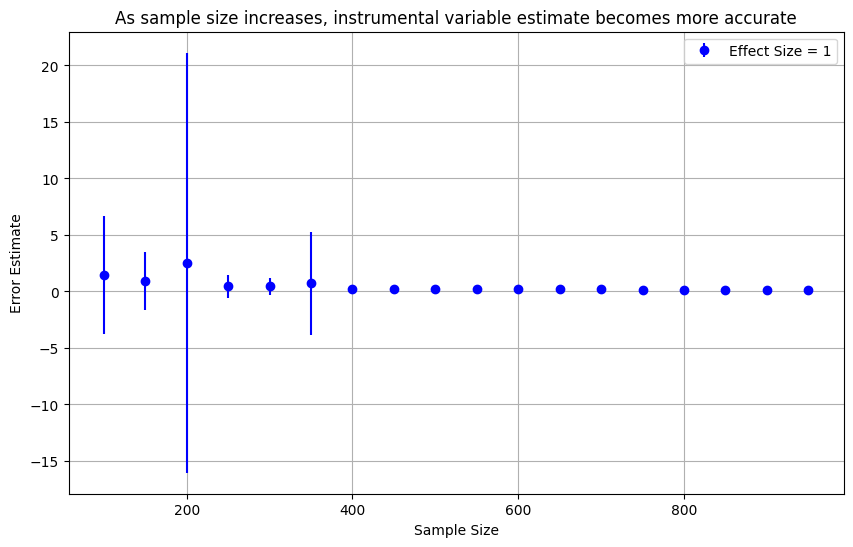

In [22]:
# Create the plot
plt.figure(figsize=(10, 6))


# Plot effect size 1
plt.errorbar('Sample Size','Error_1_Means', yerr = 'Error_1',  fmt='o', label='Effect Size = 1',data = joined_table ,color='blue')


# Add labels and title
plt.xlabel('Sample Size')
plt.ylabel('Error Estimate')
plt.title('As sample size increases, instrumental variable estimate becomes more accurate')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


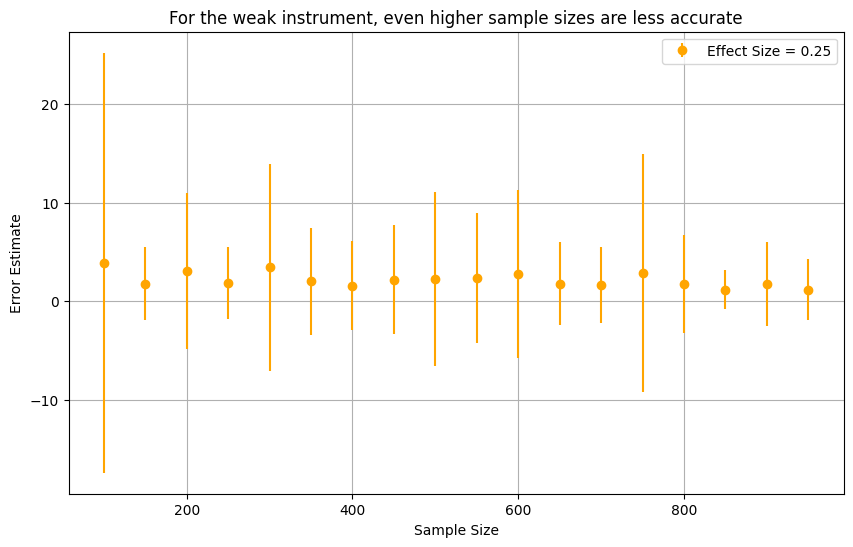

In [23]:
plt.figure(figsize=(10, 6))

# Plot effect size 0.25
plt.errorbar('Sample Size','Error_2_Means', yerr = 'Error_2',  fmt='o', label='Effect Size = 0.25', data = joined_table, color='orange')

# Add labels and title
plt.xlabel('Sample Size')
plt.ylabel('Error Estimate')
plt.title('For the weak instrument, even higher sample sizes are less accurate')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()